In [1]:
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import *
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib

In [2]:
configure_path()
setup_matplotlib()

In [3]:
def str2dt(t):
    return datetime.strptime(t[:-2] + "01", "%Y-%m-%d")

## Location of Root DNS Servers serving Venezuela

Venezuela’s absence of domestic root DNS servers renders it entirely dependent on overseas servers. We expand our analysis to investigate the locations of root DNS servers serving Venezuela since 2016.

We use RIPE Atlas’ built-in CHAOS TXT measurements, collected from probes in Venezuela, to determine the locations of DNS servers serving the country. 

In [4]:
chaos = pd.read_csv(
    "data/processed/06-16-chaos-txt/chaos_count_ve.csv",
    names=["cc", "date", "string", "city", "lat-lon"],
)
chaos["date"] = chaos["date"].map(str2dt)

In [5]:
chaos.head()

,cc,date,string,city,lat-lon
0,US,2016-01-01,mcva8.droot,Virginia,"38.94449997,-77.45580292"
1,US,2016-01-01,e-01.iad.pch.net,Virginia,"38.94449997,-77.45580292"
2,US,2016-01-01,paca3.droot,California,"37.46110153,-122.1149979"
3,US,2016-01-01,mifl3.droot,Florida,"25.79319954,-80.29060364"
4,US,2016-01-01,pao1b.f.root-servers.org,California,"37.46110153,-122.1149979"


In [6]:
c = chaos.groupby(["cc", "date"])["string"].count().reset_index()

In [7]:
c.loc[c["date"] == datetime(2023, 11, 1)]

,cc,date,string
52,AR,2023-11-01,1
98,BA,2023-11-01,1
220,BR,2023-11-01,5
256,CA,2023-11-01,1
302,CH,2023-11-01,1
331,CL,2023-11-01,1
368,CO,2023-11-01,3
378,CR,2023-11-01,1
446,DE,2023-11-01,2
531,FR,2023-11-01,3


In [8]:
prevalent_cc = (
    chaos.drop_duplicates(["date", "cc"])
    .groupby(
        [
            "cc",
        ]
    )["string"]
    .count()
    .reset_index()
)

In [9]:
TH = 12

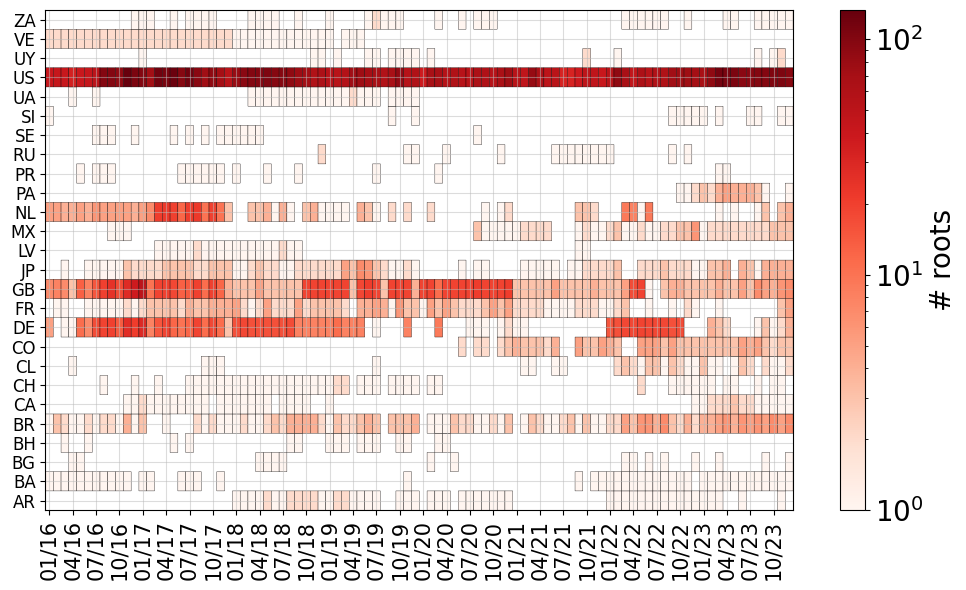

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.yaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")
ax.xaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")

p = c.loc[c["cc"].isin(prevalent_cc.loc[prevalent_cc["string"] >= TH]["cc"])].pivot(
    index="cc", columns="date"
)["string"]
t = p.columns
idx = p.index
p = p.to_numpy()

heatmap = ax.pcolor(
    p,
    norm=colors.LogNorm(
        vmin=1,
        vmax=c["string"].max(),
    ),
    cmap="Reds",
    edgecolors="k",
)

cbar = fig.colorbar(heatmap, ax=ax)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel("# roots", fontsize=20)

ax.set_yticks(np.arange(len(idx)) + 0.5)
ax.set_yticklabels(fontsize=12, labels=idx)

i = np.arange(0, len(t), 1 * 3)

ax.set_xticks(i + 0.5)
ax.set_xticklabels(
    fontsize=15, labels=[t[_i].strftime("%m/%y") for _i in i], rotation=90
)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/16-ve_chaos_all_countries.pdf")

The heatmap displays the number of servers per country in monthly snapshots reached by probes in Venezuela. It indicates that servers previously deployed within Venezuela have disappeared from our data. Despite the significant impact of losing its domestic DNS root infrastructure, Venezuela has historically relied heavily on DNS servers in the US. However, there has been a shift away from distant servers located in countries like Germany, Great Britain, France, and the Netherlands towards closer resources in Latin America, particularly in Brazil — now the second DNS source — as well as Panama and Colombia.